In [1]:
#Charger le repertoire des scripts
import sys
import os
sys.path.append(os.path.abspath('./Library'))
import numpy as np
from matplotlib.pyplot import close, show
import matplotlib.pyplot as plt
import xarray as xr
from reef_models import reef_platform, reef, reef_eros
from tools import nlines, readfile
from tools_models import CheckSimu, ZarrName, shore
from Profile import Profile
from Dicts import Dicos
from datetime import datetime as dtime
from os import path
import xsimlab as xs
from Dict_models import DicoModels
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Model setup

You only have to run the following cell, do not modify

In [3]:
dico = Dicos()
class REEF:
    
    def __init__(self):
        # Define the fixed parameters
        self.input_vars = {
            # Water height for open ocean
            'hfactor__how': 2,
            # uniform spacing
            'grid__spacing': 1,
            # Grid width factor. Should be similar to hmax 
            'grid__dmax': 20,
            # Coefficient for erosion efficiency, sea-bed
            'eros__beta1': 0.1,
            # Coefficient for erosion efficiency, cliff retreat
            'eros__beta2': 1,
            # Height of notch for volume eroded during cliff retreat
            'eros__hnotch': 1,
            # Repos angle
            'depot__repos': 15e-2,
        }

    def eros_params(self, SL, U, slop, Ev, hwb=3.):
        self.input_vars.pop('hfactor__how', None)
        self.input_vars.pop('depot__repos', None)
        self.input_vars.update({
            ## Usefull parameters to test. Everything in meters and years.
            # filename for RSL reconstruction
            'SLstory__RSLin': SL,
            # vertical land motion rate. [-10 - 2]e-3 (huge values, you can test before with 0.something e-3)
            'vertical__u': U,
            # initial slope of the substrate. [2 - 8]
            'grid__slopi': slop,          
            # Eroded volume. [50 - 1000]e-3
            'eros__Ev': Ev,
            # Water height for wave base (the waves will start to erode at this depth). [1 - 10]
            'eros__hwb': float(hwb),
        })
    
    def reef_params(self, SL, U, slop, Gm, Ev, hmax=20, Dbar=100, hwb=3.):
        self.__init__()
        # Complete the dictionnary of fixed parameters with the ones to test
        self.input_vars.update({
            ## Usefull parameters to test. Everything in meters and years.
            # filename for RSL reconstruction
            'SLstory__RSLin': SL,
            # vertical land motion rate. [-10 - 2]e-3 (huge values, you can test before with 0.something e-3)
            'vertical__u': U,
            # initial slope of the substrate. [2 - 8]
            'grid__slopi': slop,
            # maximum reef growth rate. [2 - 15]
            'construct__Gm': Gm,            
            # Eroded volume. [50 - 1000]e-3
            'eros__Ev': Ev,
            # maximum water height for reef growth. [10 - 50] 
            'construct__hmax': hmax,
            # width of wave action (controls the width of the coral reef). [10 - 3000] 
            'hfactor__Dbar': Dbar,
            # Water height for wave base (the waves will start to erode at this depth). [1 - 10]
            'eros__hwb': float(hwb),
        })
        print(self.input_vars)
        
    def run(self, dt, save, construction=True):
        self.save = save
        # Define the output of the model
        if save==True:
            output = {
                'init__x'       : None,
                'profile__z'    : 'time',
                'sealevel__asl' : 'time',
                'profile__xmin' : None,
                'profile__xmax' : None,
                'depot__dS'     : 'time',
                'construct__dG' : 'time',
            }
        elif save==False:
            output={
                'init__x'       : None,
                'profile__z'    : None,
                'sealevel__asl' : None,
                'profile__xmin' : None,
                'profile__xmax' : None,
            }
        else:
            raise Exception("Wrong format for 'save' variable. Should be True or False")

        if construction==True:
            model_type = reef
            model_name = 'reef'
        elif construction==False:
            model_type = reef_eros
            model_name = 'reef_eros'
        else:
            raise Exception("Wrong format for construction variable. Should be True or False")
            
        tmax = nlines(dico.path_SLcurves+self.input_vars['SLstory__RSLin'])*1e3
        print("Simu of", tmax/1000, "ky")
        # Create xsimlab setup
        ds_in = xs.create_setup(
            model=model_type,
            clocks={'time' : np.arange(0., tmax+dt, dt)},
            master_clock = 'time',
            input_vars = self.input_vars,
            output_vars = output
        )
        ds_in.attrs['model_name'] = model_name
        ds_in.attrs['store'] = 'Profile'

        # Run the model
        t0=dtime.today()
        dm   = DicoModels()
        with dm.models[ds_in.model_name]:
            self.ds_out = (ds_in   
              .xsimlab.run()
                  )
        print('Duration', dtime.today()-t0)
        return self.ds_out

    def plot(self, compare=False):
        if self.save==True:
            print('Starting plot')
            fig = Profile(self.ds_out)
            fig.ProfileName('.png')
            fig.PlotProfile()
            fig.PlotASL()
            fig.WriteParams()
            fig.Savefig()
            show()
            close('all')
            
        elif self.save==False:  
            # Extract SL story
            t, e = readfile(
                dico.path_SLcurves+self.input_vars['SLstory__RSLin'])

            # Create the profile plot
            fig, ax = plt.subplots(figsize=(10,6))
            # Create the initial slope, based on output offset
            init_slope = (self.ds_out.grid__slopi.values * self.ds_out.x.values
                          + self.ds_out.profile__z[0].values)
            # Define bounds
            sup = int(self.ds_out.profile__xmax) + 1000
            inf = int(self.ds_out.profile__xmin) - 1000
                        
            if compare==False:
                # Plot init topo in dashed line
                ax.plot(init_slope[inf:sup], color='black',
                        linestyle='--', linewidth=0.5, label='initial topo')
                # Plot modelled topo
                ax.plot(self.ds_out.profile__z[inf:sup], color='black',
                        label='modelled topo')
                plt.xlim(0, sup-inf)
                
            elif type(compare)==str:
                # Extracts x and y obs in the topo files
                self.x_obs, self.y_obs = readfile(
                    os.path.abspath('../Topo_obs/'+compare))
                self.align()
                ax.plot(self.x, self.y, label='modelled', color='black')
                ax.plot(self.x_obs, self.y_obs, label='observed')
                plt.legend()
                
            else:
                raise Exception("Wrong format for 'compare'. Must be string format for path")
            
            plt.xlabel('Distance (m)')
            plt.ylabel('Elevation (m)')
            plt.legend()
            
            # Add SL plot in subplot
            inset_ax = fig.add_axes([0.55, 0.18, 0.35, 0.25])
            inset_ax.plot(t, e, color='blue')
            inset_ax.set_title(self.input_vars['SLstory__RSLin'])
            inset_ax.set_xlim(0, max(t))
            inset_ax.set_xlabel('Time (ky)')
            inset_ax.set_ylabel('SL elevation (m)')   
            
        else:
            raise Exception("Wrong format for 'layers' variable. Should be True or False")

    def align(self):
        ipmin = min(self.x_obs)
        ipmax = max(self.x_obs)
        y_obs_min = min(self.y_obs)

        # Extract x and y from model output
        x = self.ds_out.profile__z.x.values
        y = self.ds_out.profile__z.values
        
        # Extract the index in y of the first element >= to the min value in y_obs.
        index_min = np.argmax(y >= y_obs_min) 
        # Use this index for the x starting value.
        x_start = x[index_min]
        
        ipmod = interp1d(x, y) # Interpolate y as a function of x.
        # Generate new continuous x values from x_start to max x value in topo_obs.
        # with the step defined in Inputs.inversion_params.
        self.x = np.arange(x_start, x_start - ipmin + ipmax, 1)
        self.y = ipmod(self.x) # Interpolation of the vertical values on new x_n axis.
        self.x = self.x - self.x[0] # Remove the offset to have x axis starting at 0.
        
REEF = REEF()

# Erosive terraces

Simu of 1001.0 ky
t 0.0
t 100.0
t 200.0
t 300.0
t 400.0
t 500.0
t 600.0
t 700.0
t 800.0
t 900.0
t 1000.0
Duration 0:00:12.630910


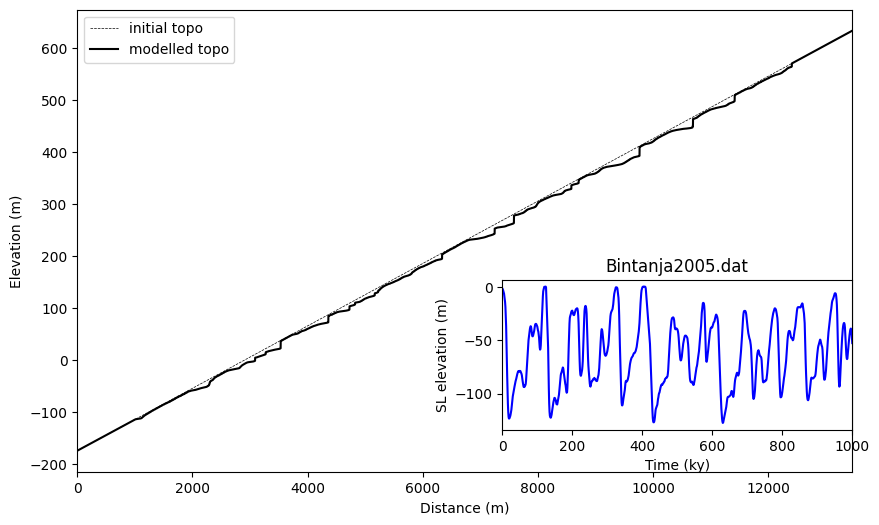

In [33]:
# Set the variables
REEF.eros_params(SL = 'Bintanja2005.dat',
                U = 0.6e-3,
                slop = 6e-2,
                Ev = 60e-3)

# Run the model
ds_out = REEF.run(dt = 200, save = False, construction=False)

# Plot the output
REEF.plot()

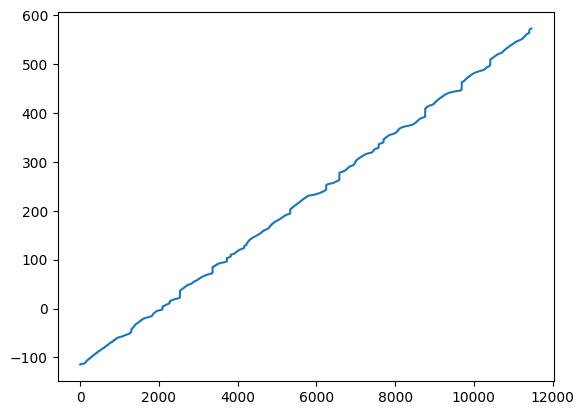

In [12]:
plt.plot(ds_out.profile__z[int(ds_out.profile__xmin.values):int(ds_out.profile__xmax.values)])
#plt.xlim(4000, 22000)
#plt.ylim(-200, 1000)

In [7]:
ds_out.profile__xmin

<xarray.DataArray 'profile__xmin' ()>
array(7428.)
Attributes:
    description:  starting index for final plot

# Simple Holocene sea-level rise

For the following cells, 3 functions are called : 
 - reef_params, which defines the model parameters
 - run, to run the model
 - plot, to plot the output

For this part, you only have to run the cells. You can modify some values in reef_params if you want.

## No vertical movement

In [ ]:
# Set the variables
REEF.reef_params(SL = 'Waelbroeck2002-137ky.dat',
                U = 0e-3,
                slop = 6e-2,
                Gm = 9e-3,
                Ev = 60e-3)

# Run the model
REEF.run(dt = 200, save = True)

# Plot the output
REEF.plot()

## Subsidence

In [ ]:
# Set the variables
REEF.reef_params(SL = 'Waelbroeck2002-137ky.dat',
                U = -0.6e-3,
                slop = 6e-2,
                Gm = 9e-3,
                Ev = 60e-3)

# Run the model
REEF.run(dt = 200, save = True)

# Plot the output
REEF.plot()

## Uplift

In [ ]:
# Set the variables
REEF.reef_params(SL = 'Waelbroeck2002-137ky.dat',
                U = 0.6e-3,
                slop = 6e-2,
                Gm = 9e-3,
                Ev = 60e-3)

# Run the model
REEF.run(dt = 200, save = True)

# Plot the output
REEF.plot()

# Reconstructing an existing geomorphology

Here, the job is to reconstruct the following topographic profile :

<img src="../Images/Profile_Cape_MIS5.png" alt="title" width="550">

This coastline has been shaped since the MIS 5e (~120 ka), and 

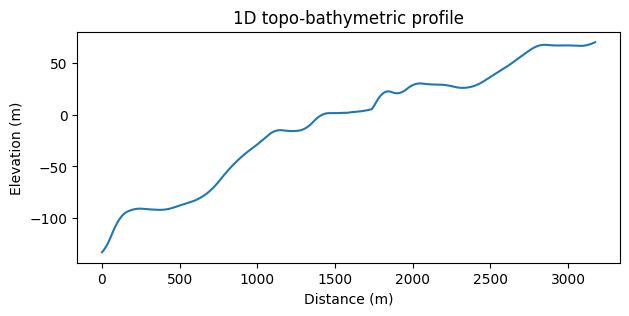

In [34]:
import matplotlib.pyplot as plt

# Créer une figure avec une taille spécifique (largeur=10 pouces, hauteur=6 pouces)
plt.figure(figsize=(7, 3))
x, y =readfile(os.path.abspath('../Topo_obs/Topo_MIS5.dat'))
# Tracer un plot simple
plt.plot(x, y)
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.title('1D topo-bathymetric profile')
#plt.xlim(1500,1900)
#plt.ylim(-10, 15)

plt.savefig('../Images/Profile_Cape_MIS5.png', dpi=300, bbox_inches='tight')

# Afficher le plot
plt.show()


Here, the job is to reconstruct the following topographic profile :

<img src="../Images/Sumba_view.png" alt="title" width="450"> <img src="../Images/Topo_Cape.png" alt="title" width="450">

This is Sumba island, in Indonesia. A benchmark for long coral records, as the oldest ones were dated at 1 Ma.

### Some questions :

 - From the profile, is it possible to approximate the eroded flux? The reef growth rate?
 - What is the local vertical movement (uplift/subsidence)?
 - Can you extract an approximation of the initial slope of the substrate from the profile?
 - Given the following sea-level curve, can you give an approximation of the vertical movement? Hint : the highest topography (~500 m) is dated at 1 Ma.



<img src="../Images/SL_Bintanja.png" alt="title" width="800">



#### From your deductions, test some values in the reef_params function.
 - U : vertical movement (positive is uplift, negative is subsidence)
 - slop : the initial slope of the substrate
 - Gm : Reef growth rate 
 - Ev : eroded flux
   
Everything in meter and year.

You can try with : <br>
Gm between 3e-3 and 10e-3 <br>
Ev between 50e-3 and 100e-3

{'hfactor__how': 2, 'grid__spacing': 1, 'grid__dmax': 20, 'eros__beta1': 0.1, 'eros__beta2': 1, 'eros__hnotch': 1, 'depot__repos': 0.15, 'SLstory__RSLin': 'Bintanja2005.dat', 'vertical__u': 0.0006, 'grid__slopi': 0.06, 'construct__Gm': 0.008, 'eros__Ev': 0.06, 'construct__hmax': 20, 'hfactor__Dbar': 100, 'eros__hwb': 3.0}
Simu of 1001.0 ky
t 0.0
t 100.0
t 200.0
t 300.0
t 400.0
t 500.0
t 600.0
t 700.0
t 800.0
t 900.0
t 1000.0
Duration 0:00:16.826573


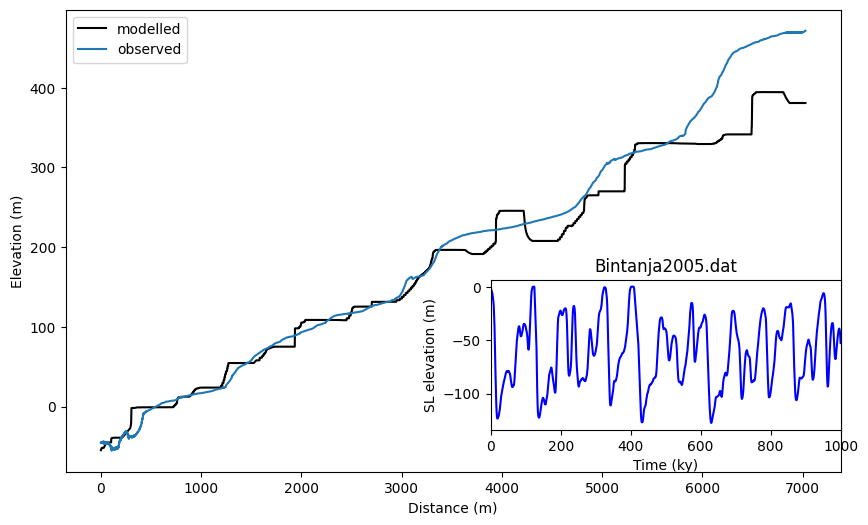

In [34]:
# Set the variables
REEF.reef_params(SL = 'Waelbroeck2002-137ky.dat',
                U = 0.6e-3,
                slop = 6e-2,
                Gm = 8e-3,
                Ev = 60e-3)

# Run the model
ds_out = REEF.run(dt = 400, save = False, construction=True)

# Plot the output
REEF.plot(compare='Laundi_dGPS_Denovan.dat')

{'hfactor__how': 2, 'grid__spacing': 1, 'grid__dmax': 20, 'eros__beta1': 0.1, 'eros__beta2': 1, 'eros__hnotch': 1, 'depot__repos': 0.15, 'SLstory__RSLin': 'Waelbroeck2002-137ky.dat', 'vertical__u': 0.00048, 'grid__slopi': 0.064, 'construct__Gm': 0.0053, 'eros__Ev': 0.072, 'construct__hmax': 20, 'hfactor__Dbar': 100, 'eros__hwb': 3.0}
Simu of 139.0 ky


/srv/conda/envs/notebook/lib/python3.10/site-packages/xsimlab/drivers.py:338: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for step, (_, ds_step) in enumerate(ds_gby_steps):


t 0.0
t 100.0
Duration 0:00:08.039397


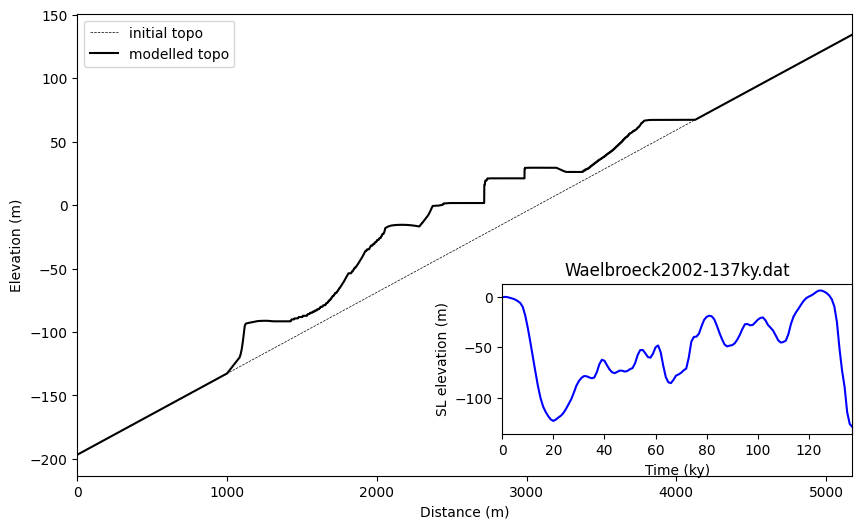

In [5]:
# Set the variables
REEF.reef_params(SL = 'Waelbroeck2002-137ky.dat',
                U = 0.48e-3,
                slop = 6.4e-2,
                Gm = 5.3e-3,
                Ev = 72e-3)

# Run the model
ds_out = REEF.run(dt = 100, save = False, construction=True)

# Plot the output
REEF.plot()

In [6]:
ds_out.profile__z

<xarray.DataArray 'profile__z' (x: 21417)>
array([-420.   , -419.936, -419.872, ...,  950.496,  950.56 ,  950.624])
Coordinates:
  * x        (x) float64 0.0 1.0 2.0 3.0 ... 2.141e+04 2.142e+04 2.142e+04
Attributes:
    description:  elevation z
    units:        m

In [7]:
# Downsample the data: take one point every 100 meters
elevation = ds_out.profile__z.values
downsample_factor = 59
x_original = ds_out.x.values
x_downsampled = x_original[::downsample_factor]
elevation_downsampled = elevation[::downsample_factor]

# Interpolate to create a smooth curve
interpolation_function = interp1d(x_downsampled, elevation_downsampled, kind='cubic')
elevation_smoothed = interpolation_function(x_original)

# Plot the original and smoothed data
plt.figure(figsize=(10, 5))
plt.plot(x_original, elevation, label='Original Data', color='gray', alpha=0.5)
plt.plot(x_original, elevation_smoothed, label='Smoothed Data (Interpolated)', color='red')
plt.scatter(x_downsampled, elevation_downsampled, color='blue', label='Downsampled Points', zorder=3)
plt.xlabel('Distance (m)')
plt.ylabel('Elevation')
plt.title('Elevation Data Smoothing with Interpolation')
plt.legend()
plt.show()

ValueError: A value (21359.0) in x_new is above the interpolation range's maximum value (21358.0).

In [51]:
ds_out

<xarray.Dataset>
Dimensions:          (x: 21417, time: 1391)
Coordinates:
  * time             (time) float64 0.0 100.0 200.0 ... 1.389e+05 1.39e+05
  * x                (x) float64 0.0 1.0 2.0 ... 2.141e+04 2.142e+04 2.142e+04
Data variables: (12/20)
    SLstory__RSLin   <U24 'Waelbroeck2002-137ky.dat'
    construct__Gm    float64 0.0053
    construct__hmax  int64 20
    depot__repos     float64 0.15
    eros__Ev         float64 0.072
    eros__beta1      float64 0.1
    ...               ...
    init__x          (x) float64 0.0 1.0 2.0 ... 2.141e+04 2.142e+04 2.142e+04
    profile__xmax    float64 7.663e+03
    profile__xmin    float64 4.488e+03
    profile__z       (x) float64 -420.0 -419.9 -419.9 ... 950.5 950.6 950.6
    sealevel__asl    float64 -0.2675
    vertical__u      float64 0.00048
Attributes:
    model_name:  reef
    store:       Profile

In [48]:
i=50
while 21417%i != 0:
    i+=1

print(i)

59


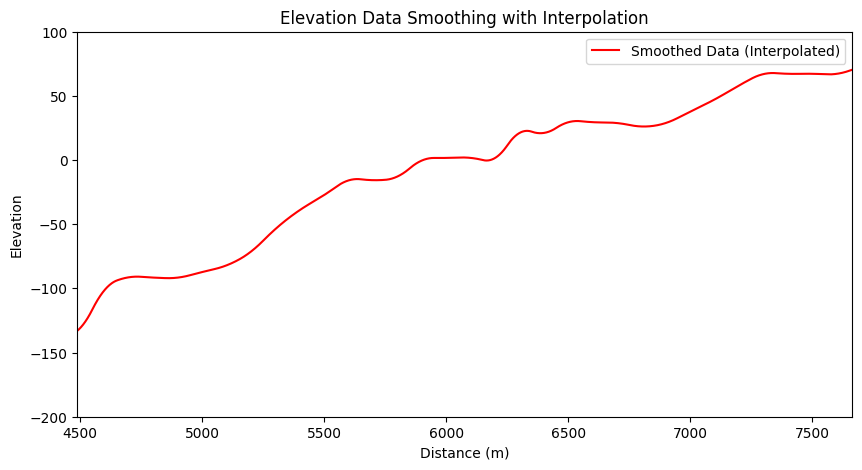

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Assuming elevation and x_original are defined
elevation = ds_out.profile__z.values
x_original = ds_out.x.values

# Downsample the data: ensure it includes the first and last points
downsample_factor = 100
x_downsampled = np.concatenate(([x_original[0]], x_original[downsample_factor:-1:downsample_factor], [x_original[-1]]))
elevation_downsampled = np.concatenate(([elevation[0]], elevation[downsample_factor:-1:downsample_factor], [elevation[-1]]))

# Interpolate to create a smooth curve
interpolation_function = interp1d(x_downsampled, elevation_downsampled, kind='quadratic', fill_value="extrapolate")
elevation_smoothed = interpolation_function(x_original)

# Plot the original and smoothed data
plt.figure(figsize=(10, 5))
#plt.plot(x_original, elevation, label='Original Data', color='gray', alpha=0.5)
plt.plot(x_original, elevation_smoothed, label='Smoothed Data (Interpolated)', color='red')
#plt.scatter(x_downsampled, elevation_downsampled, color='blue', label='Downsampled Points', zorder=3)
plt.xlabel('Distance (m)')
plt.ylabel('Elevation')
plt.xlim(ds_out.profile__xmin, ds_out.profile__xmax)
plt.ylim(-200, 100)
plt.title('Elevation Data Smoothing with Interpolation')
plt.legend()
plt.show()


In [13]:
y_cut = elevation_smoothed[int(ds_out.profile__xmin):int(ds_out.profile__xmax)].copy()
x_cut = x_original[int(ds_out.profile__xmin):int(ds_out.profile__xmax)].copy()
x_cut -= x_cut[0]

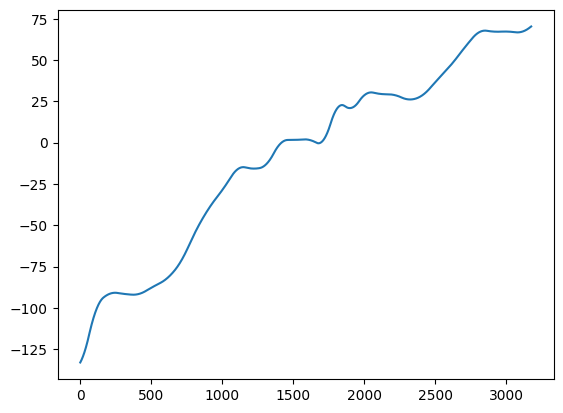

In [14]:
plt.plot(x_cut,y_cut)

In [15]:
path = '../Topo_obs/Topo'
# Put them in a 2D array.
topo_new = np.array([x_cut, y_cut])  
# Stack SL values in two columns.
topo = np.column_stack((topo_new)) 
# Save SL history in a .dat file. SAVE IT IN A TEMPORARY FILE
np.savetxt(path, topo, delimiter = '\t') 